In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.25,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_025_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:21 - loss: 1.8663 - STD: 0.0702 - MAE: 0.2059

 15/773 [..............................] - ETA: 2s - loss: 1.3937 - STD: 0.1906 - MAE: 0.1469   

 29/773 [>.............................] - ETA: 2s - loss: 1.3596 - STD: 0.1918 - MAE: 0.1459

 45/773 [>.............................] - ETA: 2s - loss: 1.3476 - STD: 0.1918 - MAE: 0.1459

 58/773 [=>............................] - ETA: 2s - loss: 1.3410 - STD: 0.1915 - MAE: 0.1459

 70/773 [=>............................] - ETA: 2s - loss: 1.3335 - STD: 0.1912 - MAE: 0.1457

 82/773 [==>...........................] - ETA: 2s - loss: 1.3260 - STD: 0.1915 - MAE: 0.1452

 94/773 [==>...........................] - ETA: 2s - loss: 1.3184 - STD: 0.1923 - MAE: 0.1446

106/773 [===>..........................] - ETA: 2s - loss: 1.3124 - STD: 0.1926 - MAE: 0.1442

119/773 [===>..........................] - ETA: 2s - loss: 1.3058 - STD: 0.1931 - MAE: 0.1438

134/773 [====>.........................] - ETA: 2s - loss: 1.2957 - STD: 0.1934 - MAE: 0.1433

149/773 [====>.........................] - ETA: 2s - loss: 1.2844 - STD: 0.1945 - MAE: 0.1426

167/773 [=====>........................] - ETA: 2s - loss: 1.2680 - STD: 0.1956 - MAE: 0.1415

184/773 [======>.......................] - ETA: 2s - loss: 1.2559 - STD: 0.1965 - MAE: 0.1408

201/773 [======>.......................] - ETA: 2s - loss: 1.2443 - STD: 0.1973 - MAE: 0.1401

215/773 [=======>......................] - ETA: 2s - loss: 1.2340 - STD: 0.1979 - MAE: 0.1395

230/773 [=======>......................] - ETA: 1s - loss: 1.2227 - STD: 0.1987 - MAE: 0.1388

245/773 [========>.....................] - ETA: 1s - loss: 1.2109 - STD: 0.1996 - MAE: 0.1381

258/773 [=========>....................] - ETA: 1s - loss: 1.2017 - STD: 0.2002 - MAE: 0.1376

273/773 [=========>....................] - ETA: 1s - loss: 1.1905 - STD: 0.2010 - MAE: 0.1369

289/773 [==========>...................] - ETA: 1s - loss: 1.1781 - STD: 0.2019 - MAE: 0.1361

306/773 [==========>...................] - ETA: 1s - loss: 1.1655 - STD: 0.2030 - MAE: 0.1352

321/773 [===========>..................] - ETA: 1s - loss: 1.1552 - STD: 0.2038 - MAE: 0.1344

337/773 [============>.................] - ETA: 1s - loss: 1.1445 - STD: 0.2048 - MAE: 0.1336

353/773 [============>.................] - ETA: 1s - loss: 1.1344 - STD: 0.2056 - MAE: 0.1329

369/773 [=============>................] - ETA: 1s - loss: 1.1246 - STD: 0.2065 - MAE: 0.1322

382/773 [=============>................] - ETA: 1s - loss: 1.1173 - STD: 0.2072 - MAE: 0.1316

399/773 [==============>...............] - ETA: 1s - loss: 1.1080 - STD: 0.2081 - MAE: 0.1309

416/773 [===============>..............] - ETA: 1s - loss: 1.0991 - STD: 0.2089 - MAE: 0.1302

432/773 [===============>..............] - ETA: 1s - loss: 1.0920 - STD: 0.2095 - MAE: 0.1297

448/773 [================>.............] - ETA: 1s - loss: 1.0846 - STD: 0.2101 - MAE: 0.1291

465/773 [=================>............] - ETA: 1s - loss: 1.0772 - STD: 0.2108 - MAE: 0.1285

482/773 [=================>............] - ETA: 1s - loss: 1.0703 - STD: 0.2115 - MAE: 0.1279

499/773 [==================>...........] - ETA: 0s - loss: 1.0636 - STD: 0.2121 - MAE: 0.1274

514/773 [==================>...........] - ETA: 0s - loss: 1.0583 - STD: 0.2126 - MAE: 0.1270

529/773 [===================>..........] - ETA: 0s - loss: 1.0529 - STD: 0.2132 - MAE: 0.1266

546/773 [====================>.........] - ETA: 0s - loss: 1.0470 - STD: 0.2137 - MAE: 0.1261

562/773 [====================>.........] - ETA: 0s - loss: 1.0420 - STD: 0.2142 - MAE: 0.1257

579/773 [=====================>........] - ETA: 0s - loss: 1.0370 - STD: 0.2146 - MAE: 0.1253

595/773 [======================>.......] - ETA: 0s - loss: 1.0325 - STD: 0.2151 - MAE: 0.1250

612/773 [======================>.......] - ETA: 0s - loss: 1.0277 - STD: 0.2155 - MAE: 0.1246

629/773 [=======================>......] - ETA: 0s - loss: 1.0231 - STD: 0.2159 - MAE: 0.1242

647/773 [========================>.....] - ETA: 0s - loss: 1.0185 - STD: 0.2164 - MAE: 0.1239

665/773 [========================>.....] - ETA: 0s - loss: 1.0141 - STD: 0.2168 - MAE: 0.1235

682/773 [=========================>....] - ETA: 0s - loss: 1.0103 - STD: 0.2172 - MAE: 0.1232

683/773 [=========================>....] - ETA: 0s - loss: 1.0102 - STD: 0.2172 - MAE: 0.1232

701/773 [==========================>...] - ETA: 0s - loss: 1.0059 - STD: 0.2176 - MAE: 0.1228

717/773 [==========================>...] - ETA: 0s - loss: 1.0021 - STD: 0.2179 - MAE: 0.1225

734/773 [===========================>..] - ETA: 0s - loss: 0.9983 - STD: 0.2183 - MAE: 0.1222

751/773 [============================>.] - ETA: 0s - loss: 0.9947 - STD: 0.2187 - MAE: 0.1219

768/773 [============================>.] - ETA: 0s - loss: 0.9914 - STD: 0.2190 - MAE: 0.1216

773/773 [==============================] - 5s 5ms/step - loss: 0.9904 - STD: 0.2191 - MAE: 0.1215 - val_loss: 0.8529 - val_STD: 0.2415 - val_MAE: 0.1029


Epoch 2/10000


  1/773 [..............................] - ETA: 15s - loss: 0.8757 - STD: 0.2437 - MAE: 0.1055

 16/773 [..............................] - ETA: 2s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1088 

 30/773 [>.............................] - ETA: 2s - loss: 0.8408 - STD: 0.2337 - MAE: 0.1092

 46/773 [>.............................] - ETA: 2s - loss: 0.8462 - STD: 0.2333 - MAE: 0.1098

 61/773 [=>............................] - ETA: 2s - loss: 0.8443 - STD: 0.2333 - MAE: 0.1096

 76/773 [=>............................] - ETA: 2s - loss: 0.8416 - STD: 0.2333 - MAE: 0.1095

 87/773 [==>...........................] - ETA: 2s - loss: 0.8388 - STD: 0.2334 - MAE: 0.1093

102/773 [==>...........................] - ETA: 2s - loss: 0.8366 - STD: 0.2339 - MAE: 0.1090

114/773 [===>..........................] - ETA: 2s - loss: 0.8338 - STD: 0.2342 - MAE: 0.1087

129/773 [====>.........................] - ETA: 2s - loss: 0.8298 - STD: 0.2345 - MAE: 0.1084

142/773 [====>.........................] - ETA: 2s - loss: 0.8283 - STD: 0.2346 - MAE: 0.1083

154/773 [====>.........................] - ETA: 2s - loss: 0.8276 - STD: 0.2346 - MAE: 0.1082

167/773 [=====>........................] - ETA: 2s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1081

182/773 [======>.......................] - ETA: 2s - loss: 0.8272 - STD: 0.2347 - MAE: 0.1081

199/773 [======>.......................] - ETA: 2s - loss: 0.8265 - STD: 0.2348 - MAE: 0.1080

212/773 [=======>......................] - ETA: 2s - loss: 0.8253 - STD: 0.2349 - MAE: 0.1080

227/773 [=======>......................] - ETA: 1s - loss: 0.8239 - STD: 0.2350 - MAE: 0.1078

244/773 [========>.....................] - ETA: 1s - loss: 0.8221 - STD: 0.2352 - MAE: 0.1076

261/773 [=========>....................] - ETA: 1s - loss: 0.8216 - STD: 0.2353 - MAE: 0.1076

274/773 [=========>....................] - ETA: 1s - loss: 0.8212 - STD: 0.2354 - MAE: 0.1075

286/773 [==========>...................] - ETA: 1s - loss: 0.8203 - STD: 0.2355 - MAE: 0.1075

298/773 [==========>...................] - ETA: 1s - loss: 0.8192 - STD: 0.2355 - MAE: 0.1074

310/773 [===========>..................] - ETA: 1s - loss: 0.8177 - STD: 0.2357 - MAE: 0.1072

325/773 [===========>..................] - ETA: 1s - loss: 0.8169 - STD: 0.2358 - MAE: 0.1072

339/773 [============>.................] - ETA: 1s - loss: 0.8159 - STD: 0.2359 - MAE: 0.1071

351/773 [============>.................] - ETA: 1s - loss: 0.8148 - STD: 0.2359 - MAE: 0.1070

365/773 [=============>................] - ETA: 1s - loss: 0.8135 - STD: 0.2361 - MAE: 0.1068

380/773 [=============>................] - ETA: 1s - loss: 0.8123 - STD: 0.2363 - MAE: 0.1067

392/773 [==============>...............] - ETA: 1s - loss: 0.8120 - STD: 0.2363 - MAE: 0.1067

406/773 [==============>...............] - ETA: 1s - loss: 0.8108 - STD: 0.2364 - MAE: 0.1066

422/773 [===============>..............] - ETA: 1s - loss: 0.8096 - STD: 0.2365 - MAE: 0.1064

436/773 [===============>..............] - ETA: 1s - loss: 0.8083 - STD: 0.2366 - MAE: 0.1064

450/773 [================>.............] - ETA: 1s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1062

462/773 [================>.............] - ETA: 1s - loss: 0.8061 - STD: 0.2368 - MAE: 0.1061

476/773 [=================>............] - ETA: 1s - loss: 0.8055 - STD: 0.2369 - MAE: 0.1061

487/773 [=================>............] - ETA: 1s - loss: 0.8051 - STD: 0.2370 - MAE: 0.1060

500/773 [==================>...........] - ETA: 1s - loss: 0.8045 - STD: 0.2370 - MAE: 0.1060

512/773 [==================>...........] - ETA: 0s - loss: 0.8043 - STD: 0.2370 - MAE: 0.1060

525/773 [===================>..........] - ETA: 0s - loss: 0.8035 - STD: 0.2371 - MAE: 0.1059

537/773 [===================>..........] - ETA: 0s - loss: 0.8031 - STD: 0.2371 - MAE: 0.1059

549/773 [====================>.........] - ETA: 0s - loss: 0.8025 - STD: 0.2372 - MAE: 0.1058

562/773 [====================>.........] - ETA: 0s - loss: 0.8017 - STD: 0.2373 - MAE: 0.1058

576/773 [=====================>........] - ETA: 0s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1057

589/773 [=====================>........] - ETA: 0s - loss: 0.8005 - STD: 0.2374 - MAE: 0.1056

604/773 [======================>.......] - ETA: 0s - loss: 0.8003 - STD: 0.2374 - MAE: 0.1056

621/773 [=======================>......] - ETA: 0s - loss: 0.7994 - STD: 0.2375 - MAE: 0.1055

635/773 [=======================>......] - ETA: 0s - loss: 0.7986 - STD: 0.2375 - MAE: 0.1055

651/773 [========================>.....] - ETA: 0s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1055

667/773 [========================>.....] - ETA: 0s - loss: 0.7974 - STD: 0.2377 - MAE: 0.1054

680/773 [=========================>....] - ETA: 0s - loss: 0.7967 - STD: 0.2377 - MAE: 0.1053

695/773 [=========================>....] - ETA: 0s - loss: 0.7960 - STD: 0.2378 - MAE: 0.1053

709/773 [==========================>...] - ETA: 0s - loss: 0.7955 - STD: 0.2379 - MAE: 0.1052

726/773 [===========================>..] - ETA: 0s - loss: 0.7949 - STD: 0.2379 - MAE: 0.1052

740/773 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1051

753/773 [============================>.] - ETA: 0s - loss: 0.7935 - STD: 0.2380 - MAE: 0.1051

765/773 [============================>.] - ETA: 0s - loss: 0.7932 - STD: 0.2381 - MAE: 0.1050

773/773 [==============================] - 3s 4ms/step - loss: 0.7927 - STD: 0.2381 - MAE: 0.1050 - val_loss: 0.7515 - val_STD: 0.2465 - val_MAE: 0.0972


Epoch 3/10000


  1/773 [..............................] - ETA: 16s - loss: 0.7775 - STD: 0.2459 - MAE: 0.1009

 14/773 [..............................] - ETA: 3s - loss: 0.7762 - STD: 0.2412 - MAE: 0.1029 

 27/773 [>.............................] - ETA: 3s - loss: 0.7730 - STD: 0.2410 - MAE: 0.1027

 40/773 [>.............................] - ETA: 2s - loss: 0.7671 - STD: 0.2413 - MAE: 0.1023

 56/773 [=>............................] - ETA: 2s - loss: 0.7639 - STD: 0.2417 - MAE: 0.1020

 71/773 [=>............................] - ETA: 2s - loss: 0.7619 - STD: 0.2414 - MAE: 0.1021

 87/773 [==>...........................] - ETA: 2s - loss: 0.7640 - STD: 0.2412 - MAE: 0.1023

104/773 [===>..........................] - ETA: 2s - loss: 0.7654 - STD: 0.2411 - MAE: 0.1025

121/773 [===>..........................] - ETA: 2s - loss: 0.7616 - STD: 0.2411 - MAE: 0.1023

138/773 [====>.........................] - ETA: 2s - loss: 0.7595 - STD: 0.2413 - MAE: 0.1021

155/773 [=====>........................] - ETA: 2s - loss: 0.7574 - STD: 0.2416 - MAE: 0.1018

168/773 [=====>........................] - ETA: 2s - loss: 0.7571 - STD: 0.2415 - MAE: 0.1018

179/773 [=====>........................] - ETA: 2s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1018

191/773 [======>.......................] - ETA: 2s - loss: 0.7574 - STD: 0.2417 - MAE: 0.1018

205/773 [======>.......................] - ETA: 2s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1018

221/773 [=======>......................] - ETA: 1s - loss: 0.7573 - STD: 0.2415 - MAE: 0.1019

237/773 [========>.....................] - ETA: 1s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1017

252/773 [========>.....................] - ETA: 1s - loss: 0.7542 - STD: 0.2418 - MAE: 0.1016

267/773 [=========>....................] - ETA: 1s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1014

283/773 [=========>....................] - ETA: 1s - loss: 0.7526 - STD: 0.2420 - MAE: 0.1014

299/773 [==========>...................] - ETA: 1s - loss: 0.7532 - STD: 0.2420 - MAE: 0.1014

315/773 [===========>..................] - ETA: 1s - loss: 0.7530 - STD: 0.2420 - MAE: 0.1014

330/773 [===========>..................] - ETA: 1s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1014

342/773 [============>.................] - ETA: 1s - loss: 0.7525 - STD: 0.2421 - MAE: 0.1013

354/773 [============>.................] - ETA: 1s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1013

370/773 [=============>................] - ETA: 1s - loss: 0.7519 - STD: 0.2421 - MAE: 0.1013

383/773 [=============>................] - ETA: 1s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1013

398/773 [==============>...............] - ETA: 1s - loss: 0.7511 - STD: 0.2421 - MAE: 0.1012

414/773 [===============>..............] - ETA: 1s - loss: 0.7508 - STD: 0.2422 - MAE: 0.1012

430/773 [===============>..............] - ETA: 1s - loss: 0.7508 - STD: 0.2422 - MAE: 0.1012

446/773 [================>.............] - ETA: 1s - loss: 0.7503 - STD: 0.2423 - MAE: 0.1011

462/773 [================>.............] - ETA: 1s - loss: 0.7498 - STD: 0.2423 - MAE: 0.1011

478/773 [=================>............] - ETA: 1s - loss: 0.7494 - STD: 0.2423 - MAE: 0.1011

494/773 [==================>...........] - ETA: 0s - loss: 0.7493 - STD: 0.2423 - MAE: 0.1011

510/773 [==================>...........] - ETA: 0s - loss: 0.7487 - STD: 0.2424 - MAE: 0.1010

526/773 [===================>..........] - ETA: 0s - loss: 0.7485 - STD: 0.2425 - MAE: 0.1009

542/773 [====================>.........] - ETA: 0s - loss: 0.7479 - STD: 0.2425 - MAE: 0.1009

559/773 [====================>.........] - ETA: 0s - loss: 0.7475 - STD: 0.2425 - MAE: 0.1009

576/773 [=====================>........] - ETA: 0s - loss: 0.7472 - STD: 0.2425 - MAE: 0.1009

592/773 [=====================>........] - ETA: 0s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1008

609/773 [======================>.......] - ETA: 0s - loss: 0.7468 - STD: 0.2426 - MAE: 0.1008

625/773 [=======================>......] - ETA: 0s - loss: 0.7460 - STD: 0.2427 - MAE: 0.1007

641/773 [=======================>......] - ETA: 0s - loss: 0.7455 - STD: 0.2427 - MAE: 0.1007

657/773 [========================>.....] - ETA: 0s - loss: 0.7449 - STD: 0.2428 - MAE: 0.1006

674/773 [=========================>....] - ETA: 0s - loss: 0.7444 - STD: 0.2428 - MAE: 0.1006

691/773 [=========================>....] - ETA: 0s - loss: 0.7441 - STD: 0.2428 - MAE: 0.1005

708/773 [==========================>...] - ETA: 0s - loss: 0.7435 - STD: 0.2429 - MAE: 0.1005

724/773 [===========================>..] - ETA: 0s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1004

741/773 [===========================>..] - ETA: 0s - loss: 0.7423 - STD: 0.2430 - MAE: 0.1004

758/773 [============================>.] - ETA: 0s - loss: 0.7422 - STD: 0.2431 - MAE: 0.1003

773/773 [==============================] - 3s 4ms/step - loss: 0.7420 - STD: 0.2431 - MAE: 0.1003 - val_loss: 0.7283 - val_STD: 0.2393 - val_MAE: 0.0996


Epoch 4/10000


  1/773 [..............................] - ETA: 19s - loss: 0.7164 - STD: 0.2404 - MAE: 0.1007

 16/773 [..............................] - ETA: 2s - loss: 0.7244 - STD: 0.2446 - MAE: 0.0986 

 33/773 [>.............................] - ETA: 2s - loss: 0.7207 - STD: 0.2447 - MAE: 0.0984

 49/773 [>.............................] - ETA: 2s - loss: 0.7204 - STD: 0.2451 - MAE: 0.0982

 64/773 [=>............................] - ETA: 2s - loss: 0.7187 - STD: 0.2450 - MAE: 0.0982

 80/773 [==>...........................] - ETA: 2s - loss: 0.7193 - STD: 0.2453 - MAE: 0.0982

 97/773 [==>...........................] - ETA: 2s - loss: 0.7180 - STD: 0.2453 - MAE: 0.0980

114/773 [===>..........................] - ETA: 2s - loss: 0.7202 - STD: 0.2453 - MAE: 0.0982

131/773 [====>.........................] - ETA: 2s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0984

148/773 [====>.........................] - ETA: 1s - loss: 0.7241 - STD: 0.2450 - MAE: 0.0986

166/773 [=====>........................] - ETA: 1s - loss: 0.7232 - STD: 0.2450 - MAE: 0.0985

183/773 [======>.......................] - ETA: 1s - loss: 0.7237 - STD: 0.2449 - MAE: 0.0985

200/773 [======>.......................] - ETA: 1s - loss: 0.7231 - STD: 0.2449 - MAE: 0.0985

217/773 [=======>......................] - ETA: 1s - loss: 0.7220 - STD: 0.2450 - MAE: 0.0984

234/773 [========>.....................] - ETA: 1s - loss: 0.7207 - STD: 0.2452 - MAE: 0.0982

250/773 [========>.....................] - ETA: 1s - loss: 0.7198 - STD: 0.2453 - MAE: 0.0981

266/773 [=========>....................] - ETA: 1s - loss: 0.7199 - STD: 0.2454 - MAE: 0.0981

282/773 [=========>....................] - ETA: 1s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0981

298/773 [==========>...................] - ETA: 1s - loss: 0.7200 - STD: 0.2452 - MAE: 0.0982

314/773 [===========>..................] - ETA: 1s - loss: 0.7194 - STD: 0.2453 - MAE: 0.0981

331/773 [===========>..................] - ETA: 1s - loss: 0.7183 - STD: 0.2454 - MAE: 0.0980

347/773 [============>.................] - ETA: 1s - loss: 0.7177 - STD: 0.2455 - MAE: 0.0979

363/773 [=============>................] - ETA: 1s - loss: 0.7178 - STD: 0.2455 - MAE: 0.0979

379/773 [=============>................] - ETA: 1s - loss: 0.7177 - STD: 0.2455 - MAE: 0.0979

395/773 [==============>...............] - ETA: 1s - loss: 0.7178 - STD: 0.2455 - MAE: 0.0979

410/773 [==============>...............] - ETA: 1s - loss: 0.7174 - STD: 0.2455 - MAE: 0.0979

427/773 [===============>..............] - ETA: 1s - loss: 0.7167 - STD: 0.2456 - MAE: 0.0978

444/773 [================>.............] - ETA: 1s - loss: 0.7164 - STD: 0.2457 - MAE: 0.0977

461/773 [================>.............] - ETA: 0s - loss: 0.7158 - STD: 0.2457 - MAE: 0.0977

478/773 [=================>............] - ETA: 0s - loss: 0.7159 - STD: 0.2458 - MAE: 0.0977

495/773 [==================>...........] - ETA: 0s - loss: 0.7156 - STD: 0.2458 - MAE: 0.0977

512/773 [==================>...........] - ETA: 0s - loss: 0.7151 - STD: 0.2458 - MAE: 0.0976

529/773 [===================>..........] - ETA: 0s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0975

546/773 [====================>.........] - ETA: 0s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0975

562/773 [====================>.........] - ETA: 0s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0975

578/773 [=====================>........] - ETA: 0s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0974

594/773 [======================>.......] - ETA: 0s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0975

610/773 [======================>.......] - ETA: 0s - loss: 0.7135 - STD: 0.2460 - MAE: 0.0974

626/773 [=======================>......] - ETA: 0s - loss: 0.7133 - STD: 0.2460 - MAE: 0.0974

643/773 [=======================>......] - ETA: 0s - loss: 0.7130 - STD: 0.2461 - MAE: 0.0974

659/773 [========================>.....] - ETA: 0s - loss: 0.7129 - STD: 0.2461 - MAE: 0.0974

676/773 [=========================>....] - ETA: 0s - loss: 0.7126 - STD: 0.2461 - MAE: 0.0973

692/773 [=========================>....] - ETA: 0s - loss: 0.7124 - STD: 0.2462 - MAE: 0.0973

708/773 [==========================>...] - ETA: 0s - loss: 0.7128 - STD: 0.2462 - MAE: 0.0973

724/773 [===========================>..] - ETA: 0s - loss: 0.7130 - STD: 0.2462 - MAE: 0.0973

741/773 [===========================>..] - ETA: 0s - loss: 0.7128 - STD: 0.2462 - MAE: 0.0973

758/773 [============================>.] - ETA: 0s - loss: 0.7125 - STD: 0.2462 - MAE: 0.0973

773/773 [==============================] - 3s 3ms/step - loss: 0.7121 - STD: 0.2462 - MAE: 0.0973 - val_loss: 0.7223 - val_STD: 0.2473 - val_MAE: 0.0958


Epoch 5/10000


  1/773 [..............................] - ETA: 13s - loss: 0.7402 - STD: 0.2454 - MAE: 0.1004

 17/773 [..............................] - ETA: 2s - loss: 0.7040 - STD: 0.2466 - MAE: 0.0969 

 33/773 [>.............................] - ETA: 2s - loss: 0.6961 - STD: 0.2474 - MAE: 0.0960

 50/773 [>.............................] - ETA: 2s - loss: 0.6962 - STD: 0.2475 - MAE: 0.0958

 66/773 [=>............................] - ETA: 2s - loss: 0.6965 - STD: 0.2475 - MAE: 0.0958

 82/773 [==>...........................] - ETA: 2s - loss: 0.6966 - STD: 0.2476 - MAE: 0.0958

 98/773 [==>...........................] - ETA: 2s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0960

114/773 [===>..........................] - ETA: 2s - loss: 0.6982 - STD: 0.2475 - MAE: 0.0959

131/773 [====>.........................] - ETA: 2s - loss: 0.6974 - STD: 0.2475 - MAE: 0.0959

148/773 [====>.........................] - ETA: 1s - loss: 0.6982 - STD: 0.2474 - MAE: 0.0960

164/773 [=====>........................] - ETA: 1s - loss: 0.6972 - STD: 0.2476 - MAE: 0.0959

180/773 [=====>........................] - ETA: 1s - loss: 0.6962 - STD: 0.2478 - MAE: 0.0957

197/773 [======>.......................] - ETA: 1s - loss: 0.6956 - STD: 0.2478 - MAE: 0.0957

213/773 [=======>......................] - ETA: 1s - loss: 0.6957 - STD: 0.2478 - MAE: 0.0957

230/773 [=======>......................] - ETA: 1s - loss: 0.6948 - STD: 0.2480 - MAE: 0.0955

246/773 [========>.....................] - ETA: 1s - loss: 0.6947 - STD: 0.2479 - MAE: 0.0956

261/773 [=========>....................] - ETA: 1s - loss: 0.6950 - STD: 0.2480 - MAE: 0.0955

276/773 [=========>....................] - ETA: 1s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0956

291/773 [==========>...................] - ETA: 1s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0955

308/773 [==========>...................] - ETA: 1s - loss: 0.6947 - STD: 0.2480 - MAE: 0.0955

324/773 [===========>..................] - ETA: 1s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0955

340/773 [============>.................] - ETA: 1s - loss: 0.6933 - STD: 0.2481 - MAE: 0.0954

356/773 [============>.................] - ETA: 1s - loss: 0.6928 - STD: 0.2481 - MAE: 0.0954

372/773 [=============>................] - ETA: 1s - loss: 0.6931 - STD: 0.2481 - MAE: 0.0954

389/773 [==============>...............] - ETA: 1s - loss: 0.6926 - STD: 0.2482 - MAE: 0.0953

405/773 [==============>...............] - ETA: 1s - loss: 0.6924 - STD: 0.2482 - MAE: 0.0953

421/773 [===============>..............] - ETA: 1s - loss: 0.6914 - STD: 0.2482 - MAE: 0.0952

438/773 [===============>..............] - ETA: 1s - loss: 0.6911 - STD: 0.2483 - MAE: 0.0952

454/773 [================>.............] - ETA: 1s - loss: 0.6909 - STD: 0.2483 - MAE: 0.0952

470/773 [=================>............] - ETA: 0s - loss: 0.6907 - STD: 0.2484 - MAE: 0.0951

486/773 [=================>............] - ETA: 0s - loss: 0.6905 - STD: 0.2484 - MAE: 0.0951

502/773 [==================>...........] - ETA: 0s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0951

518/773 [===================>..........] - ETA: 0s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0950

535/773 [===================>..........] - ETA: 0s - loss: 0.6900 - STD: 0.2485 - MAE: 0.0950

551/773 [====================>.........] - ETA: 0s - loss: 0.6900 - STD: 0.2485 - MAE: 0.0950

567/773 [=====================>........] - ETA: 0s - loss: 0.6898 - STD: 0.2485 - MAE: 0.0950

584/773 [=====================>........] - ETA: 0s - loss: 0.6897 - STD: 0.2485 - MAE: 0.0950

599/773 [======================>.......] - ETA: 0s - loss: 0.6893 - STD: 0.2485 - MAE: 0.0950

614/773 [======================>.......] - ETA: 0s - loss: 0.6890 - STD: 0.2486 - MAE: 0.0949

630/773 [=======================>......] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0949

646/773 [========================>.....] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0949

662/773 [========================>.....] - ETA: 0s - loss: 0.6885 - STD: 0.2487 - MAE: 0.0949

678/773 [=========================>....] - ETA: 0s - loss: 0.6882 - STD: 0.2487 - MAE: 0.0948

695/773 [=========================>....] - ETA: 0s - loss: 0.6880 - STD: 0.2487 - MAE: 0.0948

711/773 [==========================>...] - ETA: 0s - loss: 0.6877 - STD: 0.2487 - MAE: 0.0948

727/773 [===========================>..] - ETA: 0s - loss: 0.6877 - STD: 0.2487 - MAE: 0.0948

742/773 [===========================>..] - ETA: 0s - loss: 0.6874 - STD: 0.2488 - MAE: 0.0947

757/773 [============================>.] - ETA: 0s - loss: 0.6874 - STD: 0.2488 - MAE: 0.0947

773/773 [==============================] - ETA: 0s - loss: 0.6872 - STD: 0.2488 - MAE: 0.0947

773/773 [==============================] - 3s 3ms/step - loss: 0.6872 - STD: 0.2488 - MAE: 0.0947 - val_loss: 0.7353 - val_STD: 0.2506 - val_MAE: 0.0943


Epoch 6/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6527 - STD: 0.2549 - MAE: 0.0904

 17/773 [..............................] - ETA: 2s - loss: 0.6832 - STD: 0.2499 - MAE: 0.0944 

 34/773 [>.............................] - ETA: 2s - loss: 0.6914 - STD: 0.2491 - MAE: 0.0951

 50/773 [>.............................] - ETA: 2s - loss: 0.6905 - STD: 0.2490 - MAE: 0.0950

 66/773 [=>............................] - ETA: 2s - loss: 0.6853 - STD: 0.2494 - MAE: 0.0944

 82/773 [==>...........................] - ETA: 2s - loss: 0.6838 - STD: 0.2492 - MAE: 0.0944

 98/773 [==>...........................] - ETA: 2s - loss: 0.6856 - STD: 0.2496 - MAE: 0.0942

114/773 [===>..........................] - ETA: 2s - loss: 0.6859 - STD: 0.2494 - MAE: 0.0944

131/773 [====>.........................] - ETA: 2s - loss: 0.6863 - STD: 0.2495 - MAE: 0.0943

148/773 [====>.........................] - ETA: 1s - loss: 0.6882 - STD: 0.2493 - MAE: 0.0945

165/773 [=====>........................] - ETA: 1s - loss: 0.6878 - STD: 0.2494 - MAE: 0.0944

182/773 [======>.......................] - ETA: 1s - loss: 0.6862 - STD: 0.2494 - MAE: 0.0943

199/773 [======>.......................] - ETA: 1s - loss: 0.6854 - STD: 0.2494 - MAE: 0.0943

216/773 [=======>......................] - ETA: 1s - loss: 0.6848 - STD: 0.2494 - MAE: 0.0943

233/773 [========>.....................] - ETA: 1s - loss: 0.6845 - STD: 0.2494 - MAE: 0.0942

251/773 [========>.....................] - ETA: 1s - loss: 0.6843 - STD: 0.2495 - MAE: 0.0942

269/773 [=========>....................] - ETA: 1s - loss: 0.6830 - STD: 0.2495 - MAE: 0.0941

286/773 [==========>...................] - ETA: 1s - loss: 0.6825 - STD: 0.2496 - MAE: 0.0940

303/773 [==========>...................] - ETA: 1s - loss: 0.6815 - STD: 0.2496 - MAE: 0.0940

320/773 [===========>..................] - ETA: 1s - loss: 0.6805 - STD: 0.2497 - MAE: 0.0939

337/773 [============>.................] - ETA: 1s - loss: 0.6799 - STD: 0.2498 - MAE: 0.0938

353/773 [============>.................] - ETA: 1s - loss: 0.6792 - STD: 0.2498 - MAE: 0.0938

369/773 [=============>................] - ETA: 1s - loss: 0.6789 - STD: 0.2499 - MAE: 0.0937

386/773 [=============>................] - ETA: 1s - loss: 0.6784 - STD: 0.2499 - MAE: 0.0937

402/773 [==============>...............] - ETA: 1s - loss: 0.6775 - STD: 0.2500 - MAE: 0.0936

418/773 [===============>..............] - ETA: 1s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0935

432/773 [===============>..............] - ETA: 1s - loss: 0.6777 - STD: 0.2501 - MAE: 0.0935

447/773 [================>.............] - ETA: 1s - loss: 0.6777 - STD: 0.2500 - MAE: 0.0936

464/773 [=================>............] - ETA: 0s - loss: 0.6775 - STD: 0.2500 - MAE: 0.0935

480/773 [=================>............] - ETA: 0s - loss: 0.6772 - STD: 0.2500 - MAE: 0.0935

497/773 [==================>...........] - ETA: 0s - loss: 0.6773 - STD: 0.2500 - MAE: 0.0935

515/773 [==================>...........] - ETA: 0s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0935

531/773 [===================>..........] - ETA: 0s - loss: 0.6763 - STD: 0.2501 - MAE: 0.0935

547/773 [====================>.........] - ETA: 0s - loss: 0.6756 - STD: 0.2502 - MAE: 0.0934

563/773 [====================>.........] - ETA: 0s - loss: 0.6751 - STD: 0.2502 - MAE: 0.0933

580/773 [=====================>........] - ETA: 0s - loss: 0.6752 - STD: 0.2502 - MAE: 0.0934

596/773 [======================>.......] - ETA: 0s - loss: 0.6753 - STD: 0.2502 - MAE: 0.0934

612/773 [======================>.......] - ETA: 0s - loss: 0.6752 - STD: 0.2502 - MAE: 0.0933

628/773 [=======================>......] - ETA: 0s - loss: 0.6748 - STD: 0.2503 - MAE: 0.0933

644/773 [=======================>......] - ETA: 0s - loss: 0.6745 - STD: 0.2503 - MAE: 0.0933

660/773 [========================>.....] - ETA: 0s - loss: 0.6744 - STD: 0.2503 - MAE: 0.0933

676/773 [=========================>....] - ETA: 0s - loss: 0.6739 - STD: 0.2503 - MAE: 0.0932

691/773 [=========================>....] - ETA: 0s - loss: 0.6736 - STD: 0.2504 - MAE: 0.0932

706/773 [==========================>...] - ETA: 0s - loss: 0.6733 - STD: 0.2504 - MAE: 0.0932

722/773 [===========================>..] - ETA: 0s - loss: 0.6729 - STD: 0.2504 - MAE: 0.0931

738/773 [===========================>..] - ETA: 0s - loss: 0.6725 - STD: 0.2504 - MAE: 0.0931

754/773 [============================>.] - ETA: 0s - loss: 0.6725 - STD: 0.2504 - MAE: 0.0931

770/773 [============================>.] - ETA: 0s - loss: 0.6724 - STD: 0.2505 - MAE: 0.0931

773/773 [==============================] - 3s 3ms/step - loss: 0.6723 - STD: 0.2505 - MAE: 0.0931 - val_loss: 0.7177 - val_STD: 0.2473 - val_MAE: 0.0959


Epoch 7/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6016 - STD: 0.2501 - MAE: 0.0880

 17/773 [..............................] - ETA: 2s - loss: 0.6580 - STD: 0.2503 - MAE: 0.0926 

 33/773 [>.............................] - ETA: 2s - loss: 0.6617 - STD: 0.2506 - MAE: 0.0928

 49/773 [>.............................] - ETA: 2s - loss: 0.6613 - STD: 0.2509 - MAE: 0.0924

 66/773 [=>............................] - ETA: 2s - loss: 0.6599 - STD: 0.2512 - MAE: 0.0921

 83/773 [==>...........................] - ETA: 2s - loss: 0.6569 - STD: 0.2515 - MAE: 0.0918

 99/773 [==>...........................] - ETA: 2s - loss: 0.6570 - STD: 0.2514 - MAE: 0.0918

115/773 [===>..........................] - ETA: 2s - loss: 0.6560 - STD: 0.2515 - MAE: 0.0917

130/773 [====>.........................] - ETA: 2s - loss: 0.6559 - STD: 0.2517 - MAE: 0.0916

145/773 [====>.........................] - ETA: 2s - loss: 0.6573 - STD: 0.2520 - MAE: 0.0915

161/773 [=====>........................] - ETA: 1s - loss: 0.6559 - STD: 0.2520 - MAE: 0.0914

178/773 [=====>........................] - ETA: 1s - loss: 0.6561 - STD: 0.2520 - MAE: 0.0914

195/773 [======>.......................] - ETA: 1s - loss: 0.6561 - STD: 0.2520 - MAE: 0.0914

213/773 [=======>......................] - ETA: 1s - loss: 0.6555 - STD: 0.2520 - MAE: 0.0914

229/773 [=======>......................] - ETA: 1s - loss: 0.6548 - STD: 0.2521 - MAE: 0.0913

242/773 [========>.....................] - ETA: 1s - loss: 0.6548 - STD: 0.2520 - MAE: 0.0914

254/773 [========>.....................] - ETA: 1s - loss: 0.6553 - STD: 0.2520 - MAE: 0.0914

267/773 [=========>....................] - ETA: 1s - loss: 0.6558 - STD: 0.2520 - MAE: 0.0914

280/773 [=========>....................] - ETA: 1s - loss: 0.6558 - STD: 0.2520 - MAE: 0.0914

294/773 [==========>...................] - ETA: 1s - loss: 0.6555 - STD: 0.2521 - MAE: 0.0913

306/773 [==========>...................] - ETA: 1s - loss: 0.6551 - STD: 0.2521 - MAE: 0.0913

318/773 [===========>..................] - ETA: 1s - loss: 0.6547 - STD: 0.2521 - MAE: 0.0913

331/773 [===========>..................] - ETA: 1s - loss: 0.6543 - STD: 0.2521 - MAE: 0.0912

343/773 [============>.................] - ETA: 1s - loss: 0.6542 - STD: 0.2522 - MAE: 0.0912

356/773 [============>.................] - ETA: 1s - loss: 0.6538 - STD: 0.2522 - MAE: 0.0912

369/773 [=============>................] - ETA: 1s - loss: 0.6534 - STD: 0.2522 - MAE: 0.0911

382/773 [=============>................] - ETA: 1s - loss: 0.6544 - STD: 0.2522 - MAE: 0.0912

395/773 [==============>...............] - ETA: 1s - loss: 0.6543 - STD: 0.2522 - MAE: 0.0912

408/773 [==============>...............] - ETA: 1s - loss: 0.6545 - STD: 0.2521 - MAE: 0.0912

420/773 [===============>..............] - ETA: 1s - loss: 0.6542 - STD: 0.2522 - MAE: 0.0912

432/773 [===============>..............] - ETA: 1s - loss: 0.6537 - STD: 0.2522 - MAE: 0.0912

445/773 [================>.............] - ETA: 1s - loss: 0.6540 - STD: 0.2522 - MAE: 0.0912

458/773 [================>.............] - ETA: 1s - loss: 0.6539 - STD: 0.2522 - MAE: 0.0911

471/773 [=================>............] - ETA: 1s - loss: 0.6537 - STD: 0.2523 - MAE: 0.0911

484/773 [=================>............] - ETA: 1s - loss: 0.6536 - STD: 0.2523 - MAE: 0.0911

498/773 [==================>...........] - ETA: 1s - loss: 0.6532 - STD: 0.2523 - MAE: 0.0911

513/773 [==================>...........] - ETA: 0s - loss: 0.6530 - STD: 0.2523 - MAE: 0.0911

529/773 [===================>..........] - ETA: 0s - loss: 0.6526 - STD: 0.2524 - MAE: 0.0910

542/773 [====================>.........] - ETA: 0s - loss: 0.6524 - STD: 0.2524 - MAE: 0.0910

555/773 [====================>.........] - ETA: 0s - loss: 0.6524 - STD: 0.2524 - MAE: 0.0910

568/773 [=====================>........] - ETA: 0s - loss: 0.6525 - STD: 0.2524 - MAE: 0.0910

582/773 [=====================>........] - ETA: 0s - loss: 0.6527 - STD: 0.2525 - MAE: 0.0910

597/773 [======================>.......] - ETA: 0s - loss: 0.6525 - STD: 0.2525 - MAE: 0.0910

613/773 [======================>.......] - ETA: 0s - loss: 0.6526 - STD: 0.2525 - MAE: 0.0910

629/773 [=======================>......] - ETA: 0s - loss: 0.6526 - STD: 0.2525 - MAE: 0.0910

644/773 [=======================>......] - ETA: 0s - loss: 0.6525 - STD: 0.2525 - MAE: 0.0910

657/773 [========================>.....] - ETA: 0s - loss: 0.6527 - STD: 0.2525 - MAE: 0.0910

672/773 [=========================>....] - ETA: 0s - loss: 0.6525 - STD: 0.2525 - MAE: 0.0910

687/773 [=========================>....] - ETA: 0s - loss: 0.6523 - STD: 0.2525 - MAE: 0.0910

701/773 [==========================>...] - ETA: 0s - loss: 0.6520 - STD: 0.2525 - MAE: 0.0909

714/773 [==========================>...] - ETA: 0s - loss: 0.6518 - STD: 0.2525 - MAE: 0.0909

727/773 [===========================>..] - ETA: 0s - loss: 0.6514 - STD: 0.2526 - MAE: 0.0909

740/773 [===========================>..] - ETA: 0s - loss: 0.6511 - STD: 0.2526 - MAE: 0.0908

753/773 [============================>.] - ETA: 0s - loss: 0.6511 - STD: 0.2526 - MAE: 0.0908

766/773 [============================>.] - ETA: 0s - loss: 0.6509 - STD: 0.2526 - MAE: 0.0908

773/773 [==============================] - 3s 4ms/step - loss: 0.6507 - STD: 0.2526 - MAE: 0.0908 - val_loss: 0.7198 - val_STD: 0.2561 - val_MAE: 0.0913


Epoch 8/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6698 - STD: 0.2563 - MAE: 0.0899

 15/773 [..............................] - ETA: 2s - loss: 0.6467 - STD: 0.2509 - MAE: 0.0915 

 27/773 [>.............................] - ETA: 2s - loss: 0.6499 - STD: 0.2522 - MAE: 0.0911

 41/773 [>.............................] - ETA: 2s - loss: 0.6404 - STD: 0.2535 - MAE: 0.0898

 54/773 [=>............................] - ETA: 2s - loss: 0.6377 - STD: 0.2537 - MAE: 0.0894

 67/773 [=>............................] - ETA: 2s - loss: 0.6369 - STD: 0.2538 - MAE: 0.0893

 82/773 [==>...........................] - ETA: 2s - loss: 0.6361 - STD: 0.2541 - MAE: 0.0891

100/773 [==>...........................] - ETA: 2s - loss: 0.6361 - STD: 0.2542 - MAE: 0.0891

117/773 [===>..........................] - ETA: 2s - loss: 0.6395 - STD: 0.2541 - MAE: 0.0893

135/773 [====>.........................] - ETA: 2s - loss: 0.6404 - STD: 0.2540 - MAE: 0.0895

153/773 [====>.........................] - ETA: 2s - loss: 0.6399 - STD: 0.2540 - MAE: 0.0894

171/773 [=====>........................] - ETA: 2s - loss: 0.6401 - STD: 0.2539 - MAE: 0.0895

188/773 [======>.......................] - ETA: 1s - loss: 0.6397 - STD: 0.2539 - MAE: 0.0895

205/773 [======>.......................] - ETA: 1s - loss: 0.6402 - STD: 0.2539 - MAE: 0.0895

222/773 [=======>......................] - ETA: 1s - loss: 0.6411 - STD: 0.2538 - MAE: 0.0896

237/773 [========>.....................] - ETA: 1s - loss: 0.6405 - STD: 0.2539 - MAE: 0.0896

254/773 [========>.....................] - ETA: 1s - loss: 0.6394 - STD: 0.2539 - MAE: 0.0895

271/773 [=========>....................] - ETA: 1s - loss: 0.6394 - STD: 0.2539 - MAE: 0.0895

287/773 [==========>...................] - ETA: 1s - loss: 0.6397 - STD: 0.2540 - MAE: 0.0895

304/773 [==========>...................] - ETA: 1s - loss: 0.6395 - STD: 0.2540 - MAE: 0.0895

321/773 [===========>..................] - ETA: 1s - loss: 0.6399 - STD: 0.2539 - MAE: 0.0895

337/773 [============>.................] - ETA: 1s - loss: 0.6398 - STD: 0.2540 - MAE: 0.0895

354/773 [============>.................] - ETA: 1s - loss: 0.6394 - STD: 0.2540 - MAE: 0.0894

370/773 [=============>................] - ETA: 1s - loss: 0.6396 - STD: 0.2540 - MAE: 0.0894

386/773 [=============>................] - ETA: 1s - loss: 0.6391 - STD: 0.2540 - MAE: 0.0894

402/773 [==============>...............] - ETA: 1s - loss: 0.6386 - STD: 0.2541 - MAE: 0.0893

419/773 [===============>..............] - ETA: 1s - loss: 0.6388 - STD: 0.2540 - MAE: 0.0894

436/773 [===============>..............] - ETA: 1s - loss: 0.6384 - STD: 0.2540 - MAE: 0.0893

452/773 [================>.............] - ETA: 1s - loss: 0.6383 - STD: 0.2540 - MAE: 0.0894

469/773 [=================>............] - ETA: 0s - loss: 0.6378 - STD: 0.2540 - MAE: 0.0893

485/773 [=================>............] - ETA: 0s - loss: 0.6377 - STD: 0.2541 - MAE: 0.0893

502/773 [==================>...........] - ETA: 0s - loss: 0.6384 - STD: 0.2540 - MAE: 0.0893

519/773 [===================>..........] - ETA: 0s - loss: 0.6385 - STD: 0.2540 - MAE: 0.0894

535/773 [===================>..........] - ETA: 0s - loss: 0.6386 - STD: 0.2540 - MAE: 0.0894

552/773 [====================>.........] - ETA: 0s - loss: 0.6386 - STD: 0.2540 - MAE: 0.0894

567/773 [=====================>........] - ETA: 0s - loss: 0.6384 - STD: 0.2540 - MAE: 0.0894

583/773 [=====================>........] - ETA: 0s - loss: 0.6382 - STD: 0.2540 - MAE: 0.0894

599/773 [======================>.......] - ETA: 0s - loss: 0.6383 - STD: 0.2540 - MAE: 0.0894

615/773 [======================>.......] - ETA: 0s - loss: 0.6377 - STD: 0.2541 - MAE: 0.0893

630/773 [=======================>......] - ETA: 0s - loss: 0.6372 - STD: 0.2541 - MAE: 0.0893

645/773 [========================>.....] - ETA: 0s - loss: 0.6371 - STD: 0.2541 - MAE: 0.0892

663/773 [========================>.....] - ETA: 0s - loss: 0.6369 - STD: 0.2541 - MAE: 0.0892

679/773 [=========================>....] - ETA: 0s - loss: 0.6365 - STD: 0.2541 - MAE: 0.0892

695/773 [=========================>....] - ETA: 0s - loss: 0.6363 - STD: 0.2542 - MAE: 0.0892

711/773 [==========================>...] - ETA: 0s - loss: 0.6359 - STD: 0.2542 - MAE: 0.0891

728/773 [===========================>..] - ETA: 0s - loss: 0.6356 - STD: 0.2542 - MAE: 0.0891

746/773 [===========================>..] - ETA: 0s - loss: 0.6354 - STD: 0.2543 - MAE: 0.0891

763/773 [============================>.] - ETA: 0s - loss: 0.6356 - STD: 0.2543 - MAE: 0.0891

773/773 [==============================] - 3s 3ms/step - loss: 0.6356 - STD: 0.2543 - MAE: 0.0891 - val_loss: 0.7534 - val_STD: 0.2594 - val_MAE: 0.0909


Epoch 9/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6559 - STD: 0.2569 - MAE: 0.0896

 18/773 [..............................] - ETA: 2s - loss: 0.6170 - STD: 0.2547 - MAE: 0.0876 

 34/773 [>.............................] - ETA: 2s - loss: 0.6273 - STD: 0.2550 - MAE: 0.0881

 51/773 [>.............................] - ETA: 2s - loss: 0.6274 - STD: 0.2550 - MAE: 0.0882

 68/773 [=>............................] - ETA: 2s - loss: 0.6239 - STD: 0.2553 - MAE: 0.0878

 81/773 [==>...........................] - ETA: 2s - loss: 0.6241 - STD: 0.2552 - MAE: 0.0879

 95/773 [==>...........................] - ETA: 2s - loss: 0.6282 - STD: 0.2550 - MAE: 0.0882

112/773 [===>..........................] - ETA: 2s - loss: 0.6267 - STD: 0.2550 - MAE: 0.0881

125/773 [===>..........................] - ETA: 2s - loss: 0.6271 - STD: 0.2551 - MAE: 0.0881

139/773 [====>.........................] - ETA: 2s - loss: 0.6262 - STD: 0.2551 - MAE: 0.0880

151/773 [====>.........................] - ETA: 2s - loss: 0.6244 - STD: 0.2552 - MAE: 0.0879

165/773 [=====>........................] - ETA: 2s - loss: 0.6233 - STD: 0.2553 - MAE: 0.0878

179/773 [=====>........................] - ETA: 2s - loss: 0.6223 - STD: 0.2554 - MAE: 0.0877

192/773 [======>.......................] - ETA: 2s - loss: 0.6220 - STD: 0.2555 - MAE: 0.0876

204/773 [======>.......................] - ETA: 2s - loss: 0.6215 - STD: 0.2554 - MAE: 0.0877

218/773 [=======>......................] - ETA: 1s - loss: 0.6212 - STD: 0.2555 - MAE: 0.0876

234/773 [========>.....................] - ETA: 1s - loss: 0.6213 - STD: 0.2555 - MAE: 0.0876

247/773 [========>.....................] - ETA: 1s - loss: 0.6210 - STD: 0.2555 - MAE: 0.0876

260/773 [=========>....................] - ETA: 1s - loss: 0.6204 - STD: 0.2556 - MAE: 0.0875

273/773 [=========>....................] - ETA: 1s - loss: 0.6204 - STD: 0.2557 - MAE: 0.0875

286/773 [==========>...................] - ETA: 1s - loss: 0.6204 - STD: 0.2557 - MAE: 0.0875

299/773 [==========>...................] - ETA: 1s - loss: 0.6200 - STD: 0.2557 - MAE: 0.0874

311/773 [===========>..................] - ETA: 1s - loss: 0.6205 - STD: 0.2557 - MAE: 0.0875

323/773 [===========>..................] - ETA: 1s - loss: 0.6197 - STD: 0.2557 - MAE: 0.0874

335/773 [============>.................] - ETA: 1s - loss: 0.6198 - STD: 0.2558 - MAE: 0.0874

347/773 [============>.................] - ETA: 1s - loss: 0.6196 - STD: 0.2558 - MAE: 0.0873

360/773 [============>.................] - ETA: 1s - loss: 0.6199 - STD: 0.2558 - MAE: 0.0874

374/773 [=============>................] - ETA: 1s - loss: 0.6199 - STD: 0.2558 - MAE: 0.0874

386/773 [=============>................] - ETA: 1s - loss: 0.6197 - STD: 0.2558 - MAE: 0.0873

401/773 [==============>...............] - ETA: 1s - loss: 0.6197 - STD: 0.2558 - MAE: 0.0873

414/773 [===============>..............] - ETA: 1s - loss: 0.6201 - STD: 0.2559 - MAE: 0.0873

428/773 [===============>..............] - ETA: 1s - loss: 0.6206 - STD: 0.2559 - MAE: 0.0873

441/773 [================>.............] - ETA: 1s - loss: 0.6202 - STD: 0.2559 - MAE: 0.0873

452/773 [================>.............] - ETA: 1s - loss: 0.6200 - STD: 0.2559 - MAE: 0.0873

465/773 [=================>............] - ETA: 1s - loss: 0.6192 - STD: 0.2560 - MAE: 0.0872

478/773 [=================>............] - ETA: 1s - loss: 0.6188 - STD: 0.2560 - MAE: 0.0871

491/773 [==================>...........] - ETA: 1s - loss: 0.6184 - STD: 0.2561 - MAE: 0.0871

504/773 [==================>...........] - ETA: 1s - loss: 0.6184 - STD: 0.2561 - MAE: 0.0871

516/773 [===================>..........] - ETA: 0s - loss: 0.6185 - STD: 0.2561 - MAE: 0.0871

531/773 [===================>..........] - ETA: 0s - loss: 0.6183 - STD: 0.2561 - MAE: 0.0871

546/773 [====================>.........] - ETA: 0s - loss: 0.6178 - STD: 0.2562 - MAE: 0.0870

562/773 [====================>.........] - ETA: 0s - loss: 0.6181 - STD: 0.2561 - MAE: 0.0870

576/773 [=====================>........] - ETA: 0s - loss: 0.6180 - STD: 0.2561 - MAE: 0.0870

588/773 [=====================>........] - ETA: 0s - loss: 0.6179 - STD: 0.2562 - MAE: 0.0870

600/773 [======================>.......] - ETA: 0s - loss: 0.6179 - STD: 0.2562 - MAE: 0.0870

613/773 [======================>.......] - ETA: 0s - loss: 0.6178 - STD: 0.2562 - MAE: 0.0870

625/773 [=======================>......] - ETA: 0s - loss: 0.6176 - STD: 0.2562 - MAE: 0.0870

638/773 [=======================>......] - ETA: 0s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0869

651/773 [========================>.....] - ETA: 0s - loss: 0.6180 - STD: 0.2562 - MAE: 0.0870

666/773 [========================>.....] - ETA: 0s - loss: 0.6185 - STD: 0.2562 - MAE: 0.0870

682/773 [=========================>....] - ETA: 0s - loss: 0.6184 - STD: 0.2562 - MAE: 0.0870

694/773 [=========================>....] - ETA: 0s - loss: 0.6183 - STD: 0.2562 - MAE: 0.0870

708/773 [==========================>...] - ETA: 0s - loss: 0.6183 - STD: 0.2562 - MAE: 0.0870

721/773 [==========================>...] - ETA: 0s - loss: 0.6182 - STD: 0.2562 - MAE: 0.0870

734/773 [===========================>..] - ETA: 0s - loss: 0.6178 - STD: 0.2563 - MAE: 0.0870

747/773 [===========================>..] - ETA: 0s - loss: 0.6177 - STD: 0.2562 - MAE: 0.0870

758/773 [============================>.] - ETA: 0s - loss: 0.6176 - STD: 0.2562 - MAE: 0.0870

770/773 [============================>.] - ETA: 0s - loss: 0.6175 - STD: 0.2562 - MAE: 0.0870

773/773 [==============================] - 3s 4ms/step - loss: 0.6175 - STD: 0.2562 - MAE: 0.0870 - val_loss: 0.7413 - val_STD: 0.2625 - val_MAE: 0.0893


Epoch 10/10000


  1/773 [..............................] - ETA: 21s - loss: 0.6148 - STD: 0.2628 - MAE: 0.0846

 14/773 [..............................] - ETA: 2s - loss: 0.5956 - STD: 0.2584 - MAE: 0.0844 

 27/773 [>.............................] - ETA: 2s - loss: 0.6028 - STD: 0.2575 - MAE: 0.0852

 39/773 [>.............................] - ETA: 2s - loss: 0.6070 - STD: 0.2574 - MAE: 0.0855

 51/773 [>.............................] - ETA: 2s - loss: 0.6070 - STD: 0.2574 - MAE: 0.0856

 66/773 [=>............................] - ETA: 2s - loss: 0.6045 - STD: 0.2577 - MAE: 0.0853

 82/773 [==>...........................] - ETA: 2s - loss: 0.6041 - STD: 0.2576 - MAE: 0.0852

 94/773 [==>...........................] - ETA: 2s - loss: 0.6024 - STD: 0.2578 - MAE: 0.0851

108/773 [===>..........................] - ETA: 2s - loss: 0.6056 - STD: 0.2577 - MAE: 0.0853

125/773 [===>..........................] - ETA: 2s - loss: 0.6068 - STD: 0.2577 - MAE: 0.0853

142/773 [====>.........................] - ETA: 2s - loss: 0.6060 - STD: 0.2578 - MAE: 0.0853

159/773 [=====>........................] - ETA: 2s - loss: 0.6062 - STD: 0.2578 - MAE: 0.0853

176/773 [=====>........................] - ETA: 2s - loss: 0.6064 - STD: 0.2578 - MAE: 0.0853

193/773 [======>.......................] - ETA: 2s - loss: 0.6062 - STD: 0.2576 - MAE: 0.0854

209/773 [=======>......................] - ETA: 1s - loss: 0.6055 - STD: 0.2577 - MAE: 0.0853

226/773 [=======>......................] - ETA: 1s - loss: 0.6046 - STD: 0.2577 - MAE: 0.0853

242/773 [========>.....................] - ETA: 1s - loss: 0.6038 - STD: 0.2578 - MAE: 0.0852

258/773 [=========>....................] - ETA: 1s - loss: 0.6037 - STD: 0.2578 - MAE: 0.0852

275/773 [=========>....................] - ETA: 1s - loss: 0.6032 - STD: 0.2579 - MAE: 0.0851

291/773 [==========>...................] - ETA: 1s - loss: 0.6039 - STD: 0.2578 - MAE: 0.0852

307/773 [==========>...................] - ETA: 1s - loss: 0.6040 - STD: 0.2578 - MAE: 0.0852

323/773 [===========>..................] - ETA: 1s - loss: 0.6039 - STD: 0.2578 - MAE: 0.0852

340/773 [============>.................] - ETA: 1s - loss: 0.6033 - STD: 0.2578 - MAE: 0.0852

355/773 [============>.................] - ETA: 1s - loss: 0.6032 - STD: 0.2578 - MAE: 0.0852

371/773 [=============>................] - ETA: 1s - loss: 0.6036 - STD: 0.2578 - MAE: 0.0852

386/773 [=============>................] - ETA: 1s - loss: 0.6034 - STD: 0.2578 - MAE: 0.0852

401/773 [==============>...............] - ETA: 1s - loss: 0.6032 - STD: 0.2579 - MAE: 0.0852

413/773 [===============>..............] - ETA: 1s - loss: 0.6033 - STD: 0.2579 - MAE: 0.0851

426/773 [===============>..............] - ETA: 1s - loss: 0.6034 - STD: 0.2580 - MAE: 0.0851

438/773 [===============>..............] - ETA: 1s - loss: 0.6030 - STD: 0.2580 - MAE: 0.0851

451/773 [================>.............] - ETA: 1s - loss: 0.6029 - STD: 0.2580 - MAE: 0.0851

464/773 [=================>............] - ETA: 1s - loss: 0.6025 - STD: 0.2580 - MAE: 0.0850

477/773 [=================>............] - ETA: 1s - loss: 0.6018 - STD: 0.2581 - MAE: 0.0850

492/773 [==================>...........] - ETA: 0s - loss: 0.6014 - STD: 0.2581 - MAE: 0.0849

508/773 [==================>...........] - ETA: 0s - loss: 0.6015 - STD: 0.2581 - MAE: 0.0850

523/773 [===================>..........] - ETA: 0s - loss: 0.6017 - STD: 0.2581 - MAE: 0.0850

536/773 [===================>..........] - ETA: 0s - loss: 0.6018 - STD: 0.2581 - MAE: 0.0850

551/773 [====================>.........] - ETA: 0s - loss: 0.6014 - STD: 0.2581 - MAE: 0.0849

568/773 [=====================>........] - ETA: 0s - loss: 0.6012 - STD: 0.2581 - MAE: 0.0849

584/773 [=====================>........] - ETA: 0s - loss: 0.6013 - STD: 0.2582 - MAE: 0.0849

601/773 [======================>.......] - ETA: 0s - loss: 0.6014 - STD: 0.2581 - MAE: 0.0849

618/773 [======================>.......] - ETA: 0s - loss: 0.6009 - STD: 0.2581 - MAE: 0.0849

635/773 [=======================>......] - ETA: 0s - loss: 0.6006 - STD: 0.2582 - MAE: 0.0849

651/773 [========================>.....] - ETA: 0s - loss: 0.6002 - STD: 0.2582 - MAE: 0.0848

666/773 [========================>.....] - ETA: 0s - loss: 0.5998 - STD: 0.2582 - MAE: 0.0848

683/773 [=========================>....] - ETA: 0s - loss: 0.6001 - STD: 0.2583 - MAE: 0.0848

700/773 [==========================>...] - ETA: 0s - loss: 0.5998 - STD: 0.2583 - MAE: 0.0848

717/773 [==========================>...] - ETA: 0s - loss: 0.5995 - STD: 0.2583 - MAE: 0.0847

731/773 [===========================>..] - ETA: 0s - loss: 0.5995 - STD: 0.2583 - MAE: 0.0847

746/773 [===========================>..] - ETA: 0s - loss: 0.5995 - STD: 0.2583 - MAE: 0.0847

762/773 [============================>.] - ETA: 0s - loss: 0.5996 - STD: 0.2583 - MAE: 0.0847

773/773 [==============================] - 3s 4ms/step - loss: 0.5996 - STD: 0.2583 - MAE: 0.0847 - val_loss: 0.7792 - val_STD: 0.2619 - val_MAE: 0.0911


Epoch 11/10000


  1/773 [..............................] - ETA: 12s - loss: 0.5546 - STD: 0.2647 - MAE: 0.0773

 15/773 [..............................] - ETA: 2s - loss: 0.6037 - STD: 0.2594 - MAE: 0.0845 

 31/773 [>.............................] - ETA: 2s - loss: 0.6006 - STD: 0.2591 - MAE: 0.0844

 48/773 [>.............................] - ETA: 2s - loss: 0.5960 - STD: 0.2588 - MAE: 0.0844

 62/773 [=>............................] - ETA: 2s - loss: 0.5931 - STD: 0.2591 - MAE: 0.0841

 76/773 [=>............................] - ETA: 2s - loss: 0.5934 - STD: 0.2593 - MAE: 0.0840

 93/773 [==>...........................] - ETA: 2s - loss: 0.5927 - STD: 0.2595 - MAE: 0.0838

107/773 [===>..........................] - ETA: 2s - loss: 0.5899 - STD: 0.2595 - MAE: 0.0836

120/773 [===>..........................] - ETA: 2s - loss: 0.5892 - STD: 0.2595 - MAE: 0.0835

132/773 [====>.........................] - ETA: 2s - loss: 0.5890 - STD: 0.2595 - MAE: 0.0835

145/773 [====>.........................] - ETA: 2s - loss: 0.5886 - STD: 0.2596 - MAE: 0.0834

157/773 [=====>........................] - ETA: 2s - loss: 0.5880 - STD: 0.2596 - MAE: 0.0834

170/773 [=====>........................] - ETA: 2s - loss: 0.5880 - STD: 0.2596 - MAE: 0.0834

185/773 [======>.......................] - ETA: 2s - loss: 0.5874 - STD: 0.2596 - MAE: 0.0833

202/773 [======>.......................] - ETA: 2s - loss: 0.5876 - STD: 0.2596 - MAE: 0.0834

218/773 [=======>......................] - ETA: 2s - loss: 0.5894 - STD: 0.2596 - MAE: 0.0835

234/773 [========>.....................] - ETA: 1s - loss: 0.5892 - STD: 0.2596 - MAE: 0.0835

248/773 [========>.....................] - ETA: 1s - loss: 0.5889 - STD: 0.2596 - MAE: 0.0834

260/773 [=========>....................] - ETA: 1s - loss: 0.5882 - STD: 0.2597 - MAE: 0.0833

272/773 [=========>....................] - ETA: 1s - loss: 0.5882 - STD: 0.2596 - MAE: 0.0834

284/773 [==========>...................] - ETA: 1s - loss: 0.5877 - STD: 0.2597 - MAE: 0.0833

297/773 [==========>...................] - ETA: 1s - loss: 0.5865 - STD: 0.2598 - MAE: 0.0832

310/773 [===========>..................] - ETA: 1s - loss: 0.5862 - STD: 0.2598 - MAE: 0.0832

322/773 [===========>..................] - ETA: 1s - loss: 0.5857 - STD: 0.2598 - MAE: 0.0831

334/773 [===========>..................] - ETA: 1s - loss: 0.5856 - STD: 0.2599 - MAE: 0.0831

350/773 [============>.................] - ETA: 1s - loss: 0.5851 - STD: 0.2598 - MAE: 0.0831

363/773 [=============>................] - ETA: 1s - loss: 0.5844 - STD: 0.2599 - MAE: 0.0830

377/773 [=============>................] - ETA: 1s - loss: 0.5840 - STD: 0.2599 - MAE: 0.0829

389/773 [==============>...............] - ETA: 1s - loss: 0.5837 - STD: 0.2600 - MAE: 0.0829

401/773 [==============>...............] - ETA: 1s - loss: 0.5833 - STD: 0.2600 - MAE: 0.0828

415/773 [===============>..............] - ETA: 1s - loss: 0.5837 - STD: 0.2600 - MAE: 0.0829

427/773 [===============>..............] - ETA: 1s - loss: 0.5837 - STD: 0.2600 - MAE: 0.0829

441/773 [================>.............] - ETA: 1s - loss: 0.5838 - STD: 0.2600 - MAE: 0.0829

457/773 [================>.............] - ETA: 1s - loss: 0.5834 - STD: 0.2601 - MAE: 0.0828

473/773 [=================>............] - ETA: 1s - loss: 0.5834 - STD: 0.2601 - MAE: 0.0828

489/773 [=================>............] - ETA: 1s - loss: 0.5834 - STD: 0.2601 - MAE: 0.0828

505/773 [==================>...........] - ETA: 0s - loss: 0.5834 - STD: 0.2602 - MAE: 0.0828

521/773 [===================>..........] - ETA: 0s - loss: 0.5834 - STD: 0.2602 - MAE: 0.0828

537/773 [===================>..........] - ETA: 0s - loss: 0.5835 - STD: 0.2602 - MAE: 0.0828

554/773 [====================>.........] - ETA: 0s - loss: 0.5832 - STD: 0.2602 - MAE: 0.0827

571/773 [=====================>........] - ETA: 0s - loss: 0.5831 - STD: 0.2602 - MAE: 0.0827

588/773 [=====================>........] - ETA: 0s - loss: 0.5831 - STD: 0.2602 - MAE: 0.0827

605/773 [======================>.......] - ETA: 0s - loss: 0.5831 - STD: 0.2602 - MAE: 0.0827

622/773 [=======================>......] - ETA: 0s - loss: 0.5830 - STD: 0.2602 - MAE: 0.0827

640/773 [=======================>......] - ETA: 0s - loss: 0.5825 - STD: 0.2603 - MAE: 0.0827

657/773 [========================>.....] - ETA: 0s - loss: 0.5821 - STD: 0.2603 - MAE: 0.0826

674/773 [=========================>....] - ETA: 0s - loss: 0.5817 - STD: 0.2603 - MAE: 0.0826

692/773 [=========================>....] - ETA: 0s - loss: 0.5816 - STD: 0.2603 - MAE: 0.0826

709/773 [==========================>...] - ETA: 0s - loss: 0.5815 - STD: 0.2603 - MAE: 0.0826

727/773 [===========================>..] - ETA: 0s - loss: 0.5815 - STD: 0.2604 - MAE: 0.0825

745/773 [===========================>..] - ETA: 0s - loss: 0.5814 - STD: 0.2603 - MAE: 0.0825

763/773 [============================>.] - ETA: 0s - loss: 0.5812 - STD: 0.2604 - MAE: 0.0825

773/773 [==============================] - 3s 4ms/step - loss: 0.5811 - STD: 0.2604 - MAE: 0.0825 - val_loss: 0.7804 - val_STD: 0.2678 - val_MAE: 0.0883


Epoch 12/10000


  1/773 [..............................] - ETA: 16s - loss: 0.5428 - STD: 0.2697 - MAE: 0.0755

 15/773 [..............................] - ETA: 2s - loss: 0.5524 - STD: 0.2634 - MAE: 0.0791 

 31/773 [>.............................] - ETA: 2s - loss: 0.5563 - STD: 0.2632 - MAE: 0.0794

 48/773 [>.............................] - ETA: 2s - loss: 0.5643 - STD: 0.2621 - MAE: 0.0805

 65/773 [=>............................] - ETA: 2s - loss: 0.5662 - STD: 0.2622 - MAE: 0.0807

 81/773 [==>...........................] - ETA: 2s - loss: 0.5672 - STD: 0.2619 - MAE: 0.0808

 97/773 [==>...........................] - ETA: 2s - loss: 0.5667 - STD: 0.2619 - MAE: 0.0808

110/773 [===>..........................] - ETA: 2s - loss: 0.5664 - STD: 0.2619 - MAE: 0.0808

126/773 [===>..........................] - ETA: 2s - loss: 0.5667 - STD: 0.2619 - MAE: 0.0808

142/773 [====>.........................] - ETA: 2s - loss: 0.5679 - STD: 0.2620 - MAE: 0.0808

156/773 [=====>........................] - ETA: 2s - loss: 0.5675 - STD: 0.2621 - MAE: 0.0807

169/773 [=====>........................] - ETA: 2s - loss: 0.5666 - STD: 0.2622 - MAE: 0.0806

182/773 [======>.......................] - ETA: 2s - loss: 0.5675 - STD: 0.2622 - MAE: 0.0806

195/773 [======>.......................] - ETA: 2s - loss: 0.5676 - STD: 0.2622 - MAE: 0.0806

208/773 [=======>......................] - ETA: 1s - loss: 0.5673 - STD: 0.2622 - MAE: 0.0806

222/773 [=======>......................] - ETA: 1s - loss: 0.5677 - STD: 0.2621 - MAE: 0.0807

236/773 [========>.....................] - ETA: 1s - loss: 0.5672 - STD: 0.2622 - MAE: 0.0806

252/773 [========>.....................] - ETA: 1s - loss: 0.5671 - STD: 0.2621 - MAE: 0.0806

265/773 [=========>....................] - ETA: 1s - loss: 0.5666 - STD: 0.2621 - MAE: 0.0806

277/773 [=========>....................] - ETA: 1s - loss: 0.5662 - STD: 0.2622 - MAE: 0.0806

289/773 [==========>...................] - ETA: 1s - loss: 0.5662 - STD: 0.2622 - MAE: 0.0805

301/773 [==========>...................] - ETA: 1s - loss: 0.5663 - STD: 0.2622 - MAE: 0.0806

313/773 [===========>..................] - ETA: 1s - loss: 0.5662 - STD: 0.2621 - MAE: 0.0806

325/773 [===========>..................] - ETA: 1s - loss: 0.5659 - STD: 0.2621 - MAE: 0.0806

338/773 [============>.................] - ETA: 1s - loss: 0.5660 - STD: 0.2621 - MAE: 0.0806

350/773 [============>.................] - ETA: 1s - loss: 0.5664 - STD: 0.2621 - MAE: 0.0806

363/773 [=============>................] - ETA: 1s - loss: 0.5665 - STD: 0.2622 - MAE: 0.0806

377/773 [=============>................] - ETA: 1s - loss: 0.5666 - STD: 0.2622 - MAE: 0.0806

390/773 [==============>...............] - ETA: 1s - loss: 0.5667 - STD: 0.2622 - MAE: 0.0806

402/773 [==============>...............] - ETA: 1s - loss: 0.5664 - STD: 0.2622 - MAE: 0.0806

415/773 [===============>..............] - ETA: 1s - loss: 0.5668 - STD: 0.2622 - MAE: 0.0806

428/773 [===============>..............] - ETA: 1s - loss: 0.5666 - STD: 0.2622 - MAE: 0.0806

441/773 [================>.............] - ETA: 1s - loss: 0.5660 - STD: 0.2622 - MAE: 0.0805

454/773 [================>.............] - ETA: 1s - loss: 0.5658 - STD: 0.2622 - MAE: 0.0805

469/773 [=================>............] - ETA: 1s - loss: 0.5656 - STD: 0.2622 - MAE: 0.0805

481/773 [=================>............] - ETA: 1s - loss: 0.5654 - STD: 0.2622 - MAE: 0.0805

494/773 [==================>...........] - ETA: 1s - loss: 0.5650 - STD: 0.2623 - MAE: 0.0804

507/773 [==================>...........] - ETA: 1s - loss: 0.5649 - STD: 0.2623 - MAE: 0.0804

521/773 [===================>..........] - ETA: 0s - loss: 0.5650 - STD: 0.2623 - MAE: 0.0804

536/773 [===================>..........] - ETA: 0s - loss: 0.5647 - STD: 0.2623 - MAE: 0.0804

551/773 [====================>.........] - ETA: 0s - loss: 0.5644 - STD: 0.2623 - MAE: 0.0804

567/773 [=====================>........] - ETA: 0s - loss: 0.5649 - STD: 0.2624 - MAE: 0.0804

583/773 [=====================>........] - ETA: 0s - loss: 0.5647 - STD: 0.2624 - MAE: 0.0804

599/773 [======================>.......] - ETA: 0s - loss: 0.5645 - STD: 0.2624 - MAE: 0.0803

614/773 [======================>.......] - ETA: 0s - loss: 0.5643 - STD: 0.2624 - MAE: 0.0803

629/773 [=======================>......] - ETA: 0s - loss: 0.5641 - STD: 0.2624 - MAE: 0.0803

645/773 [========================>.....] - ETA: 0s - loss: 0.5639 - STD: 0.2625 - MAE: 0.0803

661/773 [========================>.....] - ETA: 0s - loss: 0.5641 - STD: 0.2625 - MAE: 0.0803

677/773 [=========================>....] - ETA: 0s - loss: 0.5640 - STD: 0.2625 - MAE: 0.0803

692/773 [=========================>....] - ETA: 0s - loss: 0.5637 - STD: 0.2625 - MAE: 0.0802

708/773 [==========================>...] - ETA: 0s - loss: 0.5634 - STD: 0.2625 - MAE: 0.0802

723/773 [===========================>..] - ETA: 0s - loss: 0.5633 - STD: 0.2625 - MAE: 0.0802

739/773 [===========================>..] - ETA: 0s - loss: 0.5632 - STD: 0.2625 - MAE: 0.0802

754/773 [============================>.] - ETA: 0s - loss: 0.5632 - STD: 0.2625 - MAE: 0.0802

770/773 [============================>.] - ETA: 0s - loss: 0.5629 - STD: 0.2626 - MAE: 0.0802

773/773 [==============================] - 3s 4ms/step - loss: 0.5629 - STD: 0.2626 - MAE: 0.0802 - val_loss: 0.7789 - val_STD: 0.2648 - val_MAE: 0.0897


Epoch 13/10000


  1/773 [..............................] - ETA: 12s - loss: 0.5756 - STD: 0.2677 - MAE: 0.0786

 16/773 [..............................] - ETA: 2s - loss: 0.5593 - STD: 0.2640 - MAE: 0.0790 

 29/773 [>.............................] - ETA: 2s - loss: 0.5609 - STD: 0.2634 - MAE: 0.0794

 42/773 [>.............................] - ETA: 2s - loss: 0.5561 - STD: 0.2637 - MAE: 0.0790

 55/773 [=>............................] - ETA: 2s - loss: 0.5552 - STD: 0.2637 - MAE: 0.0789

 68/773 [=>............................] - ETA: 2s - loss: 0.5533 - STD: 0.2637 - MAE: 0.0789

 82/773 [==>...........................] - ETA: 2s - loss: 0.5524 - STD: 0.2639 - MAE: 0.0787

 97/773 [==>...........................] - ETA: 2s - loss: 0.5537 - STD: 0.2639 - MAE: 0.0788

111/773 [===>..........................] - ETA: 2s - loss: 0.5543 - STD: 0.2639 - MAE: 0.0789

127/773 [===>..........................] - ETA: 2s - loss: 0.5546 - STD: 0.2640 - MAE: 0.0788

143/773 [====>.........................] - ETA: 2s - loss: 0.5546 - STD: 0.2639 - MAE: 0.0789

159/773 [=====>........................] - ETA: 2s - loss: 0.5561 - STD: 0.2639 - MAE: 0.0790

175/773 [=====>........................] - ETA: 2s - loss: 0.5567 - STD: 0.2639 - MAE: 0.0790

189/773 [======>.......................] - ETA: 2s - loss: 0.5553 - STD: 0.2640 - MAE: 0.0789

205/773 [======>.......................] - ETA: 2s - loss: 0.5552 - STD: 0.2640 - MAE: 0.0789

221/773 [=======>......................] - ETA: 1s - loss: 0.5544 - STD: 0.2640 - MAE: 0.0788

238/773 [========>.....................] - ETA: 1s - loss: 0.5547 - STD: 0.2640 - MAE: 0.0789

255/773 [========>.....................] - ETA: 1s - loss: 0.5539 - STD: 0.2641 - MAE: 0.0788

270/773 [=========>....................] - ETA: 1s - loss: 0.5535 - STD: 0.2641 - MAE: 0.0787

285/773 [==========>...................] - ETA: 1s - loss: 0.5522 - STD: 0.2641 - MAE: 0.0786

299/773 [==========>...................] - ETA: 1s - loss: 0.5515 - STD: 0.2642 - MAE: 0.0785

313/773 [===========>..................] - ETA: 1s - loss: 0.5508 - STD: 0.2642 - MAE: 0.0785

325/773 [===========>..................] - ETA: 1s - loss: 0.5506 - STD: 0.2642 - MAE: 0.0785

337/773 [============>.................] - ETA: 1s - loss: 0.5501 - STD: 0.2643 - MAE: 0.0784

350/773 [============>.................] - ETA: 1s - loss: 0.5498 - STD: 0.2643 - MAE: 0.0784

364/773 [=============>................] - ETA: 1s - loss: 0.5500 - STD: 0.2643 - MAE: 0.0784

381/773 [=============>................] - ETA: 1s - loss: 0.5501 - STD: 0.2643 - MAE: 0.0784

398/773 [==============>...............] - ETA: 1s - loss: 0.5501 - STD: 0.2643 - MAE: 0.0784

414/773 [===============>..............] - ETA: 1s - loss: 0.5500 - STD: 0.2643 - MAE: 0.0784

427/773 [===============>..............] - ETA: 1s - loss: 0.5498 - STD: 0.2643 - MAE: 0.0784

442/773 [================>.............] - ETA: 1s - loss: 0.5499 - STD: 0.2643 - MAE: 0.0784

458/773 [================>.............] - ETA: 1s - loss: 0.5501 - STD: 0.2642 - MAE: 0.0784

475/773 [=================>............] - ETA: 1s - loss: 0.5504 - STD: 0.2643 - MAE: 0.0785

491/773 [==================>...........] - ETA: 0s - loss: 0.5501 - STD: 0.2643 - MAE: 0.0784

507/773 [==================>...........] - ETA: 0s - loss: 0.5498 - STD: 0.2643 - MAE: 0.0784

523/773 [===================>..........] - ETA: 0s - loss: 0.5497 - STD: 0.2643 - MAE: 0.0784

539/773 [===================>..........] - ETA: 0s - loss: 0.5494 - STD: 0.2643 - MAE: 0.0784

556/773 [====================>.........] - ETA: 0s - loss: 0.5494 - STD: 0.2643 - MAE: 0.0784

571/773 [=====================>........] - ETA: 0s - loss: 0.5494 - STD: 0.2643 - MAE: 0.0784

588/773 [=====================>........] - ETA: 0s - loss: 0.5491 - STD: 0.2643 - MAE: 0.0783

606/773 [======================>.......] - ETA: 0s - loss: 0.5487 - STD: 0.2643 - MAE: 0.0783

623/773 [=======================>......] - ETA: 0s - loss: 0.5481 - STD: 0.2644 - MAE: 0.0782

639/773 [=======================>......] - ETA: 0s - loss: 0.5479 - STD: 0.2644 - MAE: 0.0782

655/773 [========================>.....] - ETA: 0s - loss: 0.5475 - STD: 0.2645 - MAE: 0.0782

672/773 [=========================>....] - ETA: 0s - loss: 0.5478 - STD: 0.2645 - MAE: 0.0782

687/773 [=========================>....] - ETA: 0s - loss: 0.5478 - STD: 0.2645 - MAE: 0.0781

702/773 [==========================>...] - ETA: 0s - loss: 0.5475 - STD: 0.2645 - MAE: 0.0781

719/773 [==========================>...] - ETA: 0s - loss: 0.5472 - STD: 0.2646 - MAE: 0.0781

736/773 [===========================>..] - ETA: 0s - loss: 0.5470 - STD: 0.2646 - MAE: 0.0781

751/773 [============================>.] - ETA: 0s - loss: 0.5466 - STD: 0.2646 - MAE: 0.0780

768/773 [============================>.] - ETA: 0s - loss: 0.5468 - STD: 0.2646 - MAE: 0.0780

773/773 [==============================] - 3s 4ms/step - loss: 0.5469 - STD: 0.2646 - MAE: 0.0780 - val_loss: 0.7924 - val_STD: 0.2682 - val_MAE: 0.0884


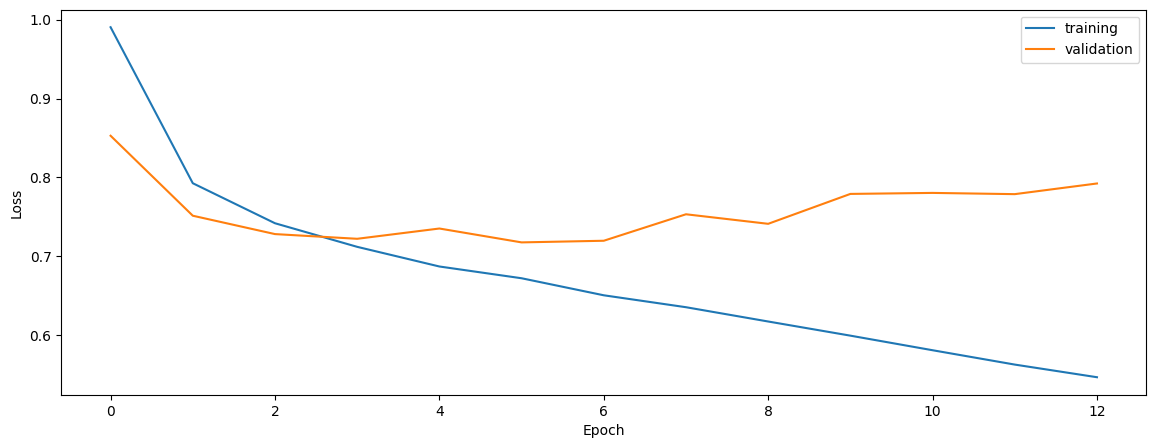

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7674856354490988
0.7459482193400249
0.7642586266959766


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7674856354490988
0.7459482193400249
0.7642586266959766


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7650293716337897
0.7558008342818
0.7649716260628668


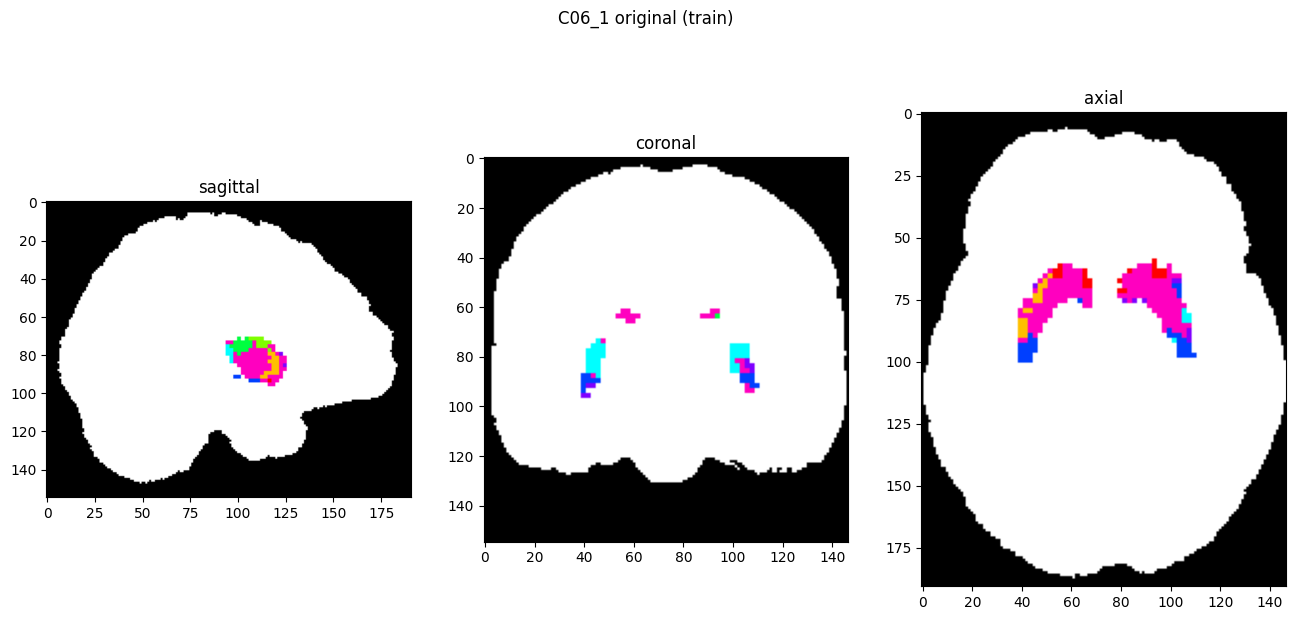

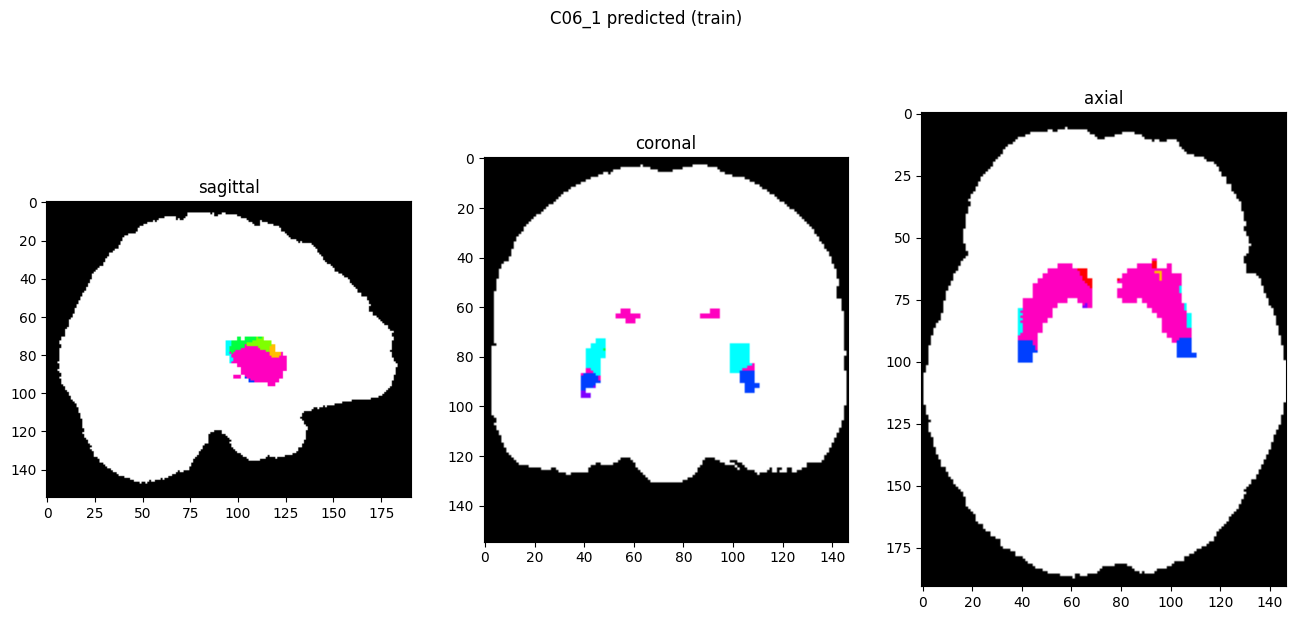

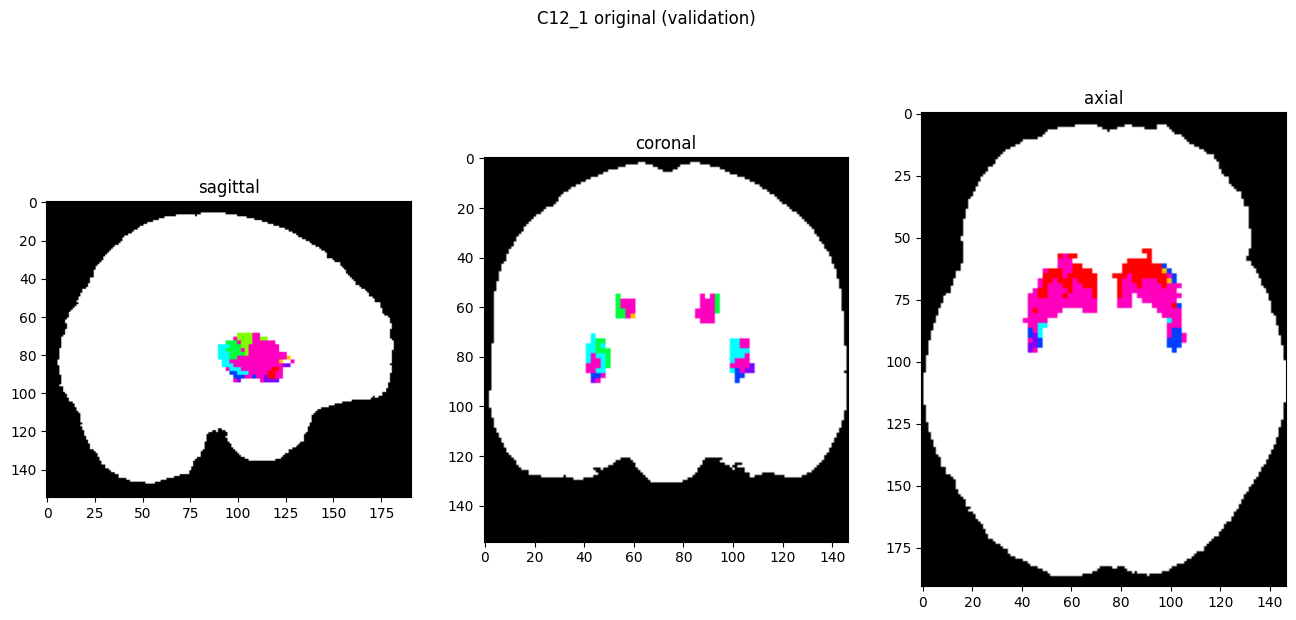

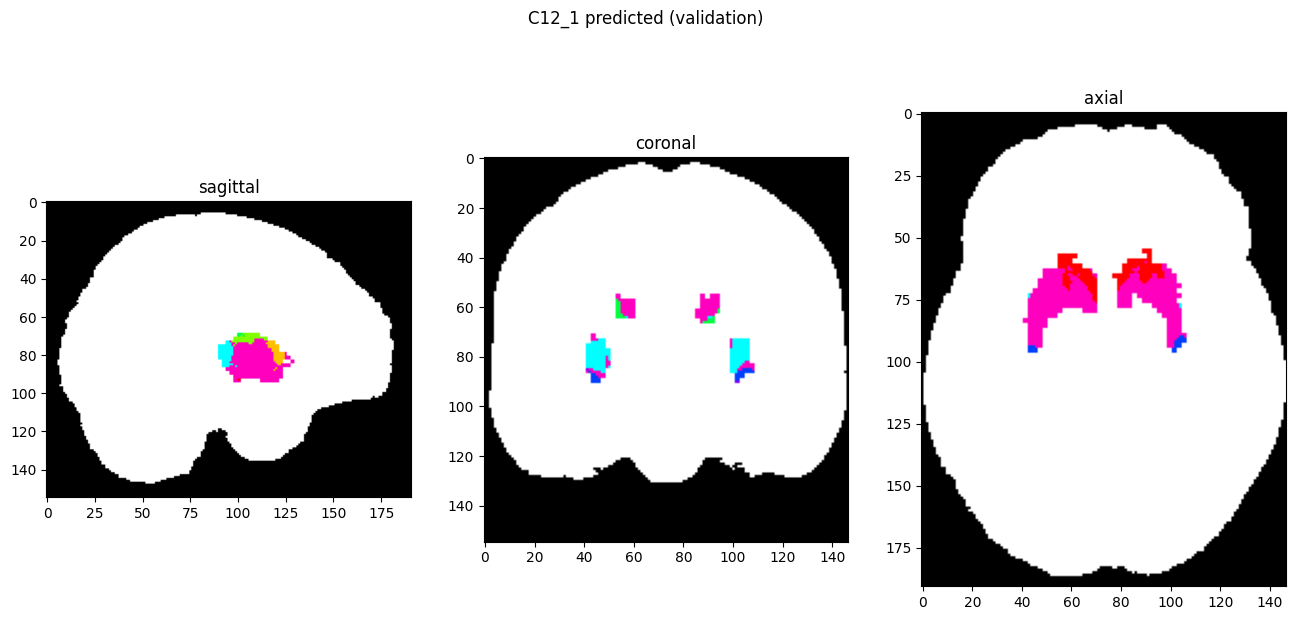

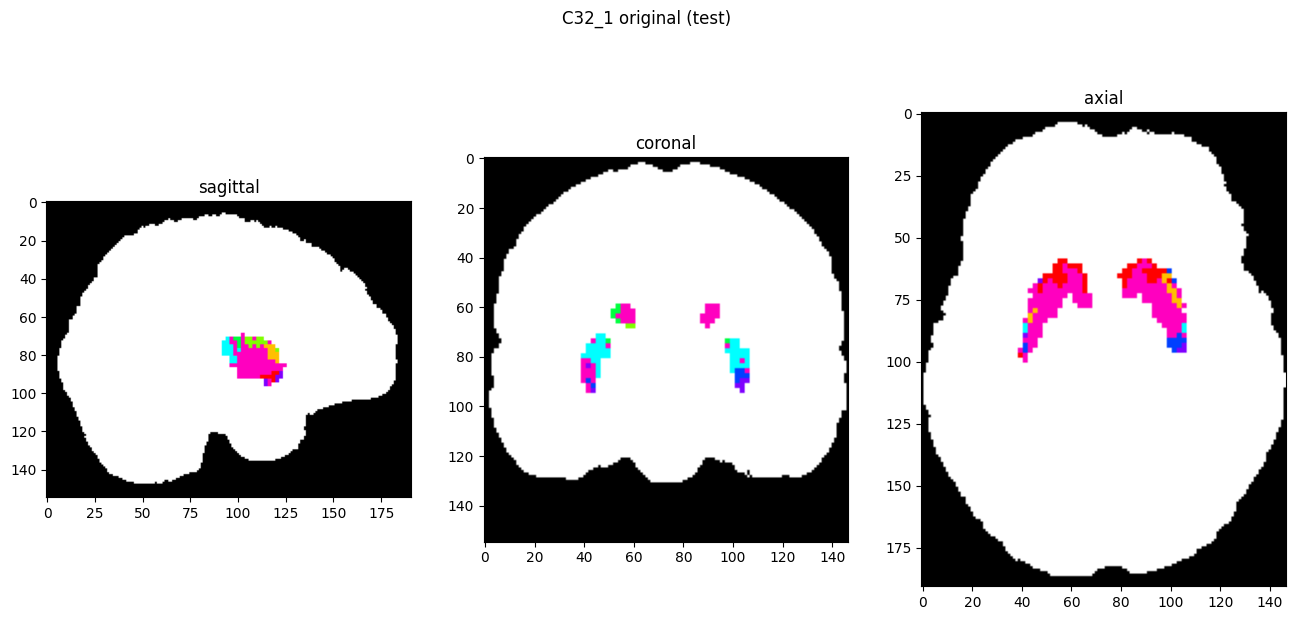

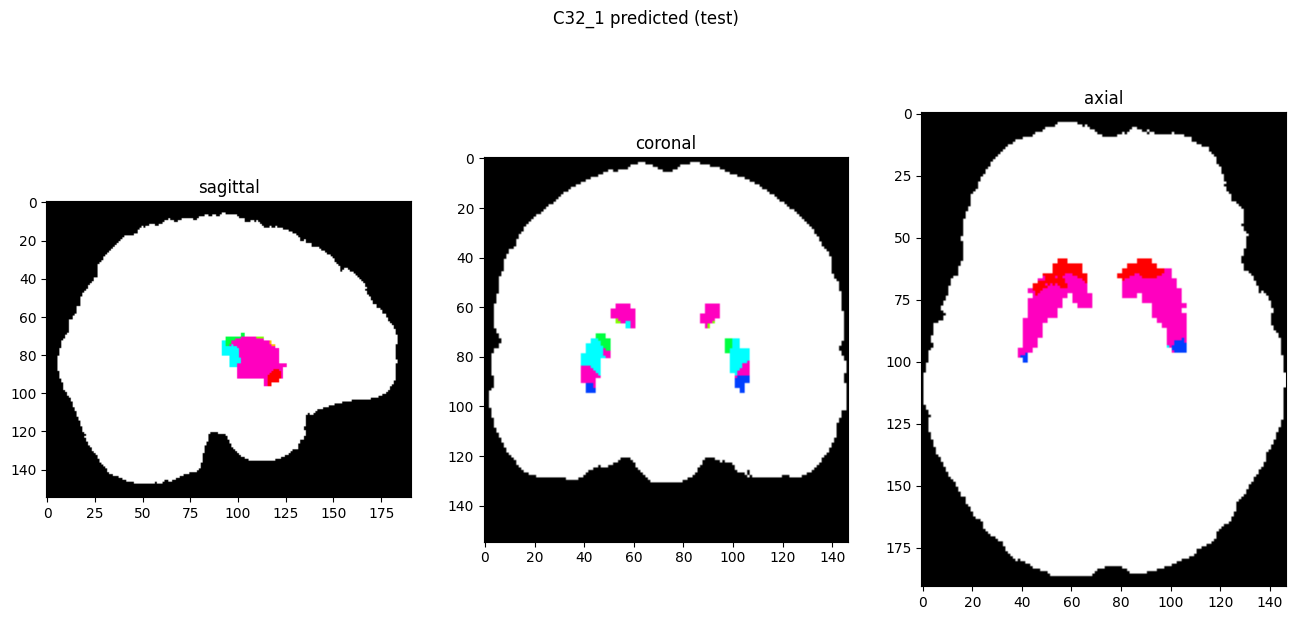

In [10]:
showResults(model, gen, threshold=0)